<a href="https://colab.research.google.com/github/JakobSchauser/BachelorProject-IceCube-ML/blob/main/Sixth_Model_(Likelihood).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral -q
 
import numpy as np
import tensorflow as tf
import keras
import pickle
import spektral
 
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteError_acc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.sparse import SparseTensor
 
from keras import backend as K
 
from time import time
 
 
from spektral.data import DisjointLoader, Dataset
from spektral.datasets import QM9
from spektral.layers import AGNNConv, GlobalSumPool, GlobalMaxPool, GlobalAvgPool, GCNConv, ECCConv
from spektral import transforms
 
from tqdm.notebook import tqdm
 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
 
PI = np.pi
 
 
# Lifehack
true = True
false = False

     |████████████████████████████████| 112kB 17.2MB/s 


In [ ]:
# !pip install wandb -q

# import wandb
# from wandb.keras import WandbCallback

# wandb.login()

In [ ]:
################################################################################
# LOAD DATA
################################################################################
# Find the reverse transformer
pcl = "/content/drive/MyDrive/Bachelor Project - IceCube ML/transformers.pkl"

with open(pcl,'rb') as tra:
    transformer = pickle.load(tra)

transformer = transformer["truth"]


class dat(Dataset):
  def __init__(self,n = 1,**kwargs):
    self.n = n
    super().__init__(**kwargs)
  def read(self):
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergy100000 0.npz" # Uncleaned
    path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergyClean200000events 0.npz" # Cleaned
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/data.dat" # From Severin
    dataset = np.load(path,allow_pickle = True)["arr_0"]
    graphs = []
    for g in dataset:
      e,a,z = g["y"]
      g["y"] = [transformer['energy_log10'].inverse_transform([[e]])[0][0],transformer['azimuth'].inverse_transform([[a]])[0][0]-PI,transformer['zenith'].inverse_transform([[z]])[0][0]]
      graphs.append(g)
    return np.array(dataset)

dataset = dat()

print("Dataset is", dataset, "consisting of", dataset[0])




#### Put on GPU when possible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Running on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Running on CPU")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Dataset is dat(n_graphs=200000) consisting of Graph(n_nodes=13, n_node_features=5, n_edge_features=None, n_labels=3)
Running on GPU


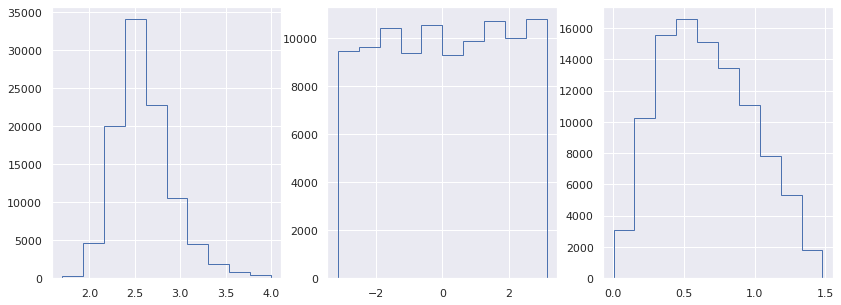

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(14,5))

N = 100000

trs = np.empty((N,3))
for k in range(N):
  trs[k] = dataset[k]["y"]

for k in range(3):
  axs[k].hist(trs[:,k],histtype="step")

In [ ]:
# from spektral.transforms import GCNFilter

# t = time.time()
# dataset.apply(GCNFilter())
# print(f"Goddamn, this takes {t-time.time():.3} seconds!")

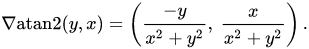

In [ ]:
# Targets are:
# 0: Energy log10
# 1: Azimuth
# 2: Zenith

# Predictions are
# 0: azimuth cos mu
# 1: azimuth cos sigma
# 2: azimuth sin mu
# 3: azimuth sin sigma
# 4: zenith cos mu
# 5: zenith cos sigma
# 6: zenith sin mu
# 7: zenith sin sigma

from tensorflow import math as tmath
atan2errprop = lambda x,y: tmath.sqrt(tmath.square(x)+tmath.square(y))/(tmath.square(x)+tmath.square(y))

sqrt2pi = np.sqrt(2*PI)

def custom_loss(target,predictions):
    predictions = tf.cast(predictions,"float64")
    acmu, acsigma = predictions[:,0], predictions[:,1]
    asmu, assigma = predictions[:,2], predictions[:,3]

    # zcmu, zcsigma = predictions[:,0], predictions[:,1]
    # zsmu, zssigma = predictions[:,2], predictions[:,3]

    acx = tmath.cos(target[:,1])
    asx = tmath.sin(target[:,1])

    # loggauss = lambda x, mu, sigma: tmath.log(tf.clip_by_value(tf.inverse_no_nan(sqrt2pi*sigma),1e-12,1e12)) - 0.5*tmath.square(tmath.divide_no_nan((x-mu),sigma))

    #for inverse sigma
    loggauss = lambda x, mu, sigma: tmath.log(tf.clip_by_value(sigma/sqrt2pi,1e-12,1e12)) - 0.5*tmath.square((x-mu)*sigma)

    acLLH = -loggauss(acx,acmu,acsigma)
    asLLH = -loggauss(asx,asmu,assigma)

    comb = acLLH + asLLH

    mean = tf.reduce_mean(comb)

    return mean

loss_fn = custom_loss


def custom_acc(target,predictions):
    predictions = tf.cast(predictions,"float64")

    
    # energy    = tf.abs(target[:,0] - predictions[:,0])

    aziguess = tf.atan2(predictions[:,2],predictions[:,0])
    azi = tf.minimum( tf.abs(target[:,1] - aziguess) , tf.abs(tf.abs(target[:,1] - aziguess) - 2*PI))

    acos_sigma, asin_sigma = predictions[:,1], predictions[:,3]

    # zeniguess = tf.atan2(predictions[:,4],predictions[:,3])
    # zeni = tf.minimum( tf.abs(target[:,2] - zeniguess) , tf.abs(tf.abs(target[:,2] - zeniguess) - 2*PI))
    

    return azi, atan2errprop(acos_sigma, asin_sigma)

acc_fn = custom_acc

def scale_inputs(inputs):
    inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
    inputs[0][:,3] = inputs[0][:,3]/10000 # time
    inputs[0][:,4] = inputs[0][:,4]/1 # charge
    return inputs


def lr_schedule(start_lr,epoch,total_epochs):
  return start_lr
  # return start_lr/((1+epoch/total_epochs)*5)
  if epoch < total_epochs//4:
    return start_lr*(1+epoch/(total_epochs//4))
  return 2*start_lr/(10*epoch/total_epochs)

In [ ]:
################################################################################
# PARAMETERS
################################################################################
#@markdown ### Define the model and training parameters and sync with WandB
batch_size =  32#@param {type: "number"}
 
# one-variable network size changer
network_size =  32#@param {type: "number"}
 
learning_rate =   1e-4#@param {type: "number"}
 
training_epochs = 30 #@param {type: "slider", min: 10, max: 200}
 
early_stopping_rounds =  7#@param {type: "number"}
 
dropout_rate = 0.1 #@param {type: "number"}
 
loss_function = "custom_loss"  #@param ['custom_loss',"rasmus_loss"]
 
config = {
        "learning_rate": learning_rate,
        "epochs": training_epochs,
        "batch_size": batch_size,
        "loss_function": loss_function,
        "architecture": "Broadening CNN - short but wide",
        "network_size": network_size,
        "dropout_rate": dropout_rate,
        "dataset": "MuonGun",
        "early_stopping_rounds": early_stopping_rounds,
      }
 
epochs = config["epochs"]  # Number of training epochs
test_epochs = 2 # Number of testing epochs

In [ ]:
# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
# n_out = dataset.n_labels  # Dimension of the target
n_out = 4

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

train_loader = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, shuffle=True)
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)





class model_class(Model):
  def __init__(self):
    super().__init__()
    
    self.preprocess = transforms.layer_preprocess.LayerPreprocess(GCNConv)

    # self.inp = ECCConv(network_size//4)

    self.steps = [2**i for i in range(4)]
    self.convs = [GCNConv(network_size*s,activation="gelu") for s in self.steps]

    self.maxpool = GlobalMaxPool()
    self.avgpool = GlobalAvgPool()
    self.sumpool = GlobalSumPool()

    self.denses = [Dense(network_size*s,activation= "gelu") for s in self.steps[::-1]]
    self.dropouts = [Dropout(dropout_rate) for s in self.steps]
    # self.normalizations = [BatchNormalization() for s in self.steps]

    self.out = Dense(n_out)
    # self.oneout = Dense(1)

  def call(self, inputs, training = False):

    x, a, i = inputs
    # a, e    = self.generate_edge_features(x, a) # NEXT STEP is implementing this for myself
    # x = self.inp([x,a,e])
    # a = self.preprocess(a)
    for conv in self.convs:
      x = conv([x,a])
    
    
    xm = self.maxpool([x,i])
    xa = self.avgpool([x,i])
    xs = self.sumpool([x,i])

    x = tf.concat([xm, xa, xs], axis = 1) 


    for dense, dropout in zip(self.denses,self.dropouts):
      # x = norm(x) # ,training = training # batch_normalization is broken in curretn keras
      x = dense(x)
      x = dropout(x,training = training)


    out = self.out(x)

    # xe = self.smalldense(x)
    # xa = self.smalldense(x)
    # xz = self.smalldense(x)

    # oute = self.oneout(xe)
    # outa1 = self.oneout(xa)
    # outa2 = self.oneout(xa)

    # outz1 = self.oneout(xz)
    # outz2 = self.oneout(xz)


    return out
    # return tf.concat([oute, outa1,outa2, outz1,outz2], axis = 1) 


  #Shamelessly stolen from Johann
  def generate_edge_features(self, x, a):
      send    = a.indices[:, 0]
      receive = a.indices[:, 1]

      diff_x  = tf.subtract(tf.gather(x, receive), tf.gather(x, send))

      dists   = tf.sqrt(
        tf.reduce_sum(
          tf.square(
            diff_x[:, :3]
          ), axis = 1
        ))

      vects = tf.math.divide_no_nan(diff_x[:, :3], tf.expand_dims(dists, axis = -1))

      e = tf.concat([diff_x[:, 3:], tf.expand_dims(dists, -1), vects], axis = 1)

      return a, e

# Build model
model = model_class()

opt = Adam(lr=learning_rate,clipvalue=1)
loss_fn = custom_loss
# loss_fn = MeanAbsoluteError()
acc_fn = custom_acc


model.compile()
# model.build()
# fit(train_loader)

In [ ]:
################################################################################
# DEFINE TF-FUNCTIONS
################################################################################
@tf.function(input_signature=train_loader.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    acc = acc_fn(target,predictions)

    return loss, acc

def validate(inputs,target):
    predictions = model(inputs, training=False)
    loss = loss_fn(target, predictions)
    loss += sum(model.losses)
    acc = acc_fn(target,predictions)

    return loss, acc






loss_fn = custom_loss
acc_fn = custom_acc
def fit(train_loader,logwandb = False):
  if logwandb:
    run = wandb.init(project='IceCube GNN Bachelor',config = config)

  current_batch = 0
  model_loss = []
  model_acc = []
  vali_loss = []
  epoch = 0

  earlystop = 0
  should_stop = False

  epoch_steps = train_loader.steps_per_epoch

  t = tqdm(total  = train_loader.steps_per_epoch,leave = True, ncols='70%')
  t.set_description(f'Currently on epoch {0} of {epochs} ')

  pb = []
  tar = []
  step = 0

  last_loss = 0
  
  for batch in train_loader:
      if should_stop:
        print("Ending fitting because of early stopping")
        break

      step += 1
      inputs, target = batch
      inputs = scale_inputs(inputs)

      loss, acc = train_step(inputs,target)

      model_loss.append(loss)
      model_acc.append(acc)
      current_batch += 1
      t.update(1)

      if step%100 == 0:
        t.set_description(f'Current loss {np.mean(model_loss):.3} | Working on epoch {epoch} of {epochs}:')

      if current_batch == epoch_steps:
          test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)
          t.set_description(f'Currently validating results for epoch {epoch} of {epochs}:')

          for vali_batch in test_loader:
            vali_inputs, vali_target = vali_batch
            valie_inputs = scale_inputs(vali_inputs)
            valoss, vaacc = validate(vali_inputs,vali_target)
            vali_loss.append(valoss)
          va = np.mean(vali_loss)

          m_loss = np.mean(model_loss)
          change = (m_loss-last_loss)/max(0.000001,last_loss)
          last_loss = m_loss

          s = "Train loss: {} - Loss change {:+.3f}% | Validation loss {} | Epoch: {}".format(m_loss, change*100,va, epoch)
          t.write(s)

          if m_loss < va:
            if earlystop < early_stopping_rounds:
              earlystop += 1
            else:
              should_stop = True
          else:
            earlystop = 0



          if epoch%10 == 0:
            # maybe write a saving state here
            pass
          ma = np.array(model_acc)
          s = "Azimuth: mu {} | sigma {}".format(np.mean(ma[:,0]),np.mean(ma[:,1]))
          t.write(s)
          # print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])

          # if epoch%5 == 0 and epoch != 0:
            # print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])
            # pass
          # else:
            # pb = model(inputs, training=False)
            # tar = target



          if logwandb:
            wandb.log({
                      "train_loss": m_loss,
                      "energy_accuracy": np.mean(ma[:,0]),
                      "azimuth_accuracy": np.mean(ma[:,1]),
                      "zenith_accuracy": np.mean(ma[:,2]),
                      "val_loss": va,
                      })




          model_loss = []
          model_acc = []
          vali_loss = []
          current_batch = 0
          step = 0

          t.n = 0
          t.last_print_n = 0
          t.refresh()

          epoch += 1


          K.set_value(model.optimizer.learning_rate, lr_schedule(learning_rate,epoch,epochs))




In [ ]:
 logwandb = false

fit(train_loader,logwandb = logwandb)

print("\n\nTraining of the following model is now complete:")
model.summary()
save_path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models"


if logwandb:
  pth = save_path + f"/{wandb.run.name}-run"
  wandb.run.finish()  
else:
  pth = save_path + "/AzimuthWithLikelihood"

model.save(pth)

Train loss: 462209.74469407956 - Loss change +46220974469407.961% | Validation loss 2.2046859074137073 | Epoch: 0
Azimuth: mu 1.5459266772890818 | sigma 0.8778555382481448
Train loss: 2.204084245926002 - Loss change -100.000% | Validation loss 2.068102416370302 | Epoch: 1
Azimuth: mu 1.4530386625650027 | sigma 0.5139412678322689
Train loss: 2.092752846143065 - Loss change -5.051% | Validation loss 2.0331714457523837 | Epoch: 2
Azimuth: mu 1.3772334426092787 | sigma 0.48917077625821637
Train loss: 2.059620654758508 - Loss change -1.583% | Validation loss 2.0538554369604967 | Epoch: 3
Azimuth: mu 1.3294240347994428 | sigma 0.48178504840295694
Train loss: 2.0379322493160705 - Loss change -1.053% | Validation loss 1.9932570853010534 | Epoch: 4
Azimuth: mu 1.2844171080750584 | sigma 0.4768871356911309
Train loss: 2.015978314253252 - Loss change -1.077% | Validation loss 1.9602782404855286 | Epoch: 5
Azimuth: mu 1.2416534857251122 | sigma 0.4718063539604878
Train loss: 1.963912833274429 - Lo

KeyboardInterrupt: ignored

In [ ]:
 
# model = keras.models.load_model("/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models/magic-tree-71-run")

@tf.function(input_signature=test_loader.tf_signature(), experimental_relax_shapes=True)
def get_predictions(inputs,target):
  return model(inputs,training = False)

@tf.function(input_signature=test_loader.tf_signature(), experimental_relax_shapes=True)
def get_true_guesses(inputs,target):
  pred = model(inputs,training = False)
  mu = tf.atan2(pred[:,0],pred[:,2])
  acos_sigma, asin_sigma = pred[:,1], pred[:,3]
  
  sigma = atan2errprop(acos_sigma, asin_sigma)
  return (mu, sigma)

  
def make1D(a):
  new = []
  for aa in a:
    for aaa in aa:
      new.append(aaa)
  return np.array(new)

def test_model():
  test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=10,shuffle = True)

  predictions, truths = [],[]

  for batch in tqdm(test_loader,total = test_loader.steps_per_epoch*test_loader.epochs):
    inputs, target = batch
    inputs = scale_inputs(inputs) 

    pred = get_predictions(inputs,target)

    true_guesses = get_true_guesses(inputs,target)

    predictions.append(true_guesses)
    truths.append(np.array(target))
    
    # print(pred)
  
  # model_acc = np.array(model_acc)
  # print(f"Done! \nModel loss {np.mean(model_loss)} | Energy accuracy {np.mean(model_acc[:,0])} | Azimuth accuracy {np.mean(model_acc[:,1])} | Zenith accuracy {np.mean(model_acc[:,2])}")
  return predictions, truths



In [ ]:
# predictions, truths = test_model()
predictions = np.array(predictions)

energies = predictions[:,0].ravel()
sigmas = predictions[:,1].ravel()
t_energies = np.array(truths)[:,:,1].ravel()

safe = abs(sigmas)<0.2

diffs = (energies[safe] - t_energies[safe])/PI*180
plt.hist(diffs,bins = 50,histtype="step")
# t_energies
# plt.hist(t_energies,bins = 50,histtype="step")
# plt.hist(energies[safe],bins = 50,histtype="step")
plt.show()